In [6]:
import numpy as np
import qilisdk
import qutip as qt
import matplotlib.pyplot as plt
import sys

sys.path.append('../src')

import hamiltonian
import dynamics
import plots
import estimator
import VQE

from qilisdk.backends import QutipBackend
from qilisdk.digital import Circuit, M, U1, CNOT, U2, U3, CZ, RX, RZ, H
from qilisdk.functionals.sampling import Sampling, SamplingResult
from qilisdk.functionals.time_evolution import TimeEvolution
from scipy.optimize import minimize

from qilisdk.analog import Schedule, X, Z, Y
from qilisdk.core import ket, tensor_prod
from qilisdk.backends import QutipBackend, CudaBackend
from qilisdk.functionals import TimeEvolution

## Generate Hamiltonian

In [7]:
nqubits = 3

# target_weights = [0.5, 0.8]
# H_target = hamiltonian.create_hamiltonian_from_weights(nqubits, target_weights)

min_w = -1
max_w = 1
H_target, target_weights = hamiltonian.create_random_hamiltonian(nqubits, min_w, max_w, backend='qilisdk')


print("Target Hamilonian: \n", H_target.H, "\n")
print("Target weights:", target_weights)

Target Hamilonian: 
 0.9049649424797939 X(0) + 0.5659263815088713 Z(0) + 0.4298812675176147 Z(0) Z(1) + 0.6060209607502538 Z(0) Z(2) + 0.27008325530111943 X(1) - 0.772255163231792 Z(1) - 0.754207691427609 Z(1) Z(2) + 0.9264435500502566 X(2) - 0.5249806934852705 Z(2) 

Target weights: [ 0.90496494  0.27008326  0.92644355  0.56592638 -0.77225516 -0.52498069
  0.42988127  0.60602096 -0.75420769]


## Create target trajectory

In [8]:
ti = 0
times = np.linspace(0.01, 3, 20)

initial_zero_state = tensor_prod([ket(0).unit() for _ in range(nqubits)]).unit()
#initial_minus_state = tensor_prod([(ket(0) - ket(1)).unit() for _ in range(nqubits)]).unit()

Hx = sum(X(i) for i in range(nqubits)) #Driver

target_states = []
target_x, target_y, target_z = [], [], []
T_final = times[-1]
for T in times:
    dt = T/100
    steps = np.linspace(0, T, int(T / dt))
    sim = VQE.simulate_annealing(T, dt, T_final, steps, Hx, H_target.H, initial_zero_state)
    #save expectation values
    target_x.append(sim.final_expected_values[0])
    target_y.append(sim.final_expected_values[1])
    target_z.append(sim.final_expected_values[2])

    #save final state as qutip object
    target_state_data = sim.final_state.data
    target_state_array = target_state_data.toarray()
    target_qutip_state = qt.Qobj(target_state_array, dims=[[2]*nqubits, [1]])

    target_states.append(target_qutip_state)

In [9]:
# Define Hamiltonians
alpha = 1.
initial_weights = np.random.uniform(min_w, max_w, size=(2*nqubits + int(nqubits*(nqubits-1)/2)))

options={
    'maxiter': 2000,           # Increase iterations
    'ftol': 1e-10,            # Function tolerance
    'gtol': 1e-8,             # Gradient tolerance  
    'maxfun': 10000,          # Max function evaluations
    'disp': True              # Print convergence messages
    }

alphas = np.linspace(1, 0, 1)
losses = []
leraned_parameters = []
observables = [target_x, target_y, target_z]

print("target_weights:", target_weights)
print("initial_weights:", initial_weights)
for alpha in alphas:
    print("Alpha = ", alpha)
    final_result = VQE.learn_hamiltonian(nqubits, initial_weights, Hx, initial_zero_state, target_states, times, alpha, observables = observables, optimizer_options = options, mode = "segmented")
    print("Loss = ", final_result.fun)
    print("Params:", final_result.x)
    losses.append(final_result.fun)
    leraned_parameters.append(final_result.x)

target_weights: [ 0.90496494  0.27008326  0.92644355  0.56592638 -0.77225516 -0.52498069
  0.42988127  0.60602096 -0.75420769]
initial_weights: [ 0.86493445  0.02145328  0.79755601 -0.48791767  0.45033393 -0.07050256
 -0.24528563 -0.26001922  0.8217751 ]
Alpha =  1.0
Loss =  3.2991238729795924e-06
Params: [ 0.90549205  0.26199035  0.93052833  0.56904593 -0.78906245 -0.50207856
  0.42923644  0.60539255 -0.73457744]


3.2991238729795924e-06


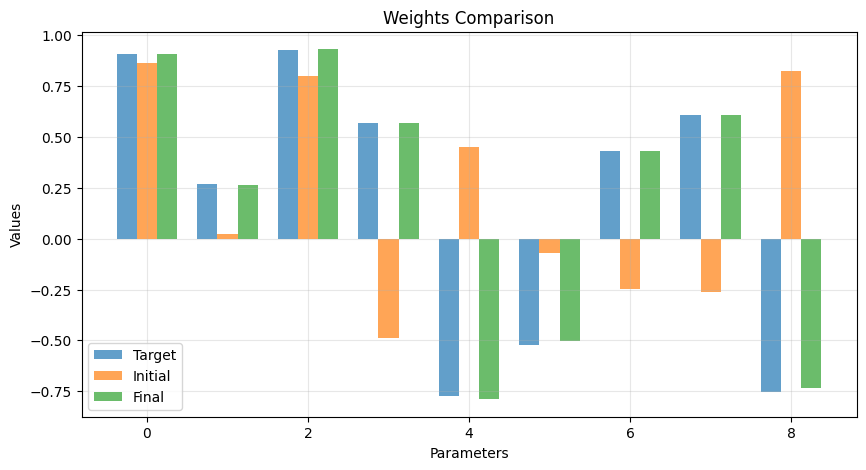

In [10]:
print(final_result.fun)
final_weights = final_result.x
plots.plot_weights(target_weights, initial_weights, final_weights)